## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
print(X.isna().sum())
X = X.dropna()
# В наборе данных отсутствуют пропущенные значения категориальные переменные.
y = y[~np.isnan(y)]

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split

# stratify необходим для получения пропорционально сбалансированных тренировочной и тестовой выборок (пропорции объектов одного класса должна быть примерно одинаковыми)
# Важно для равнозначных цен ошибок.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Масштабируем признаки.
normalizer = StandardScaler()
X_train_norm_np = normalizer.fit_transform(X_train)
X_test_norm_np = normalizer.fit_transform(X_test)

X_train_norm = pd.DataFrame(data=X_train_norm_np, columns=X_train.columns)
X_test_norm = pd.DataFrame(data=X_test_norm_np, columns=X_test.columns)


n_neighbors = [1, 3, 5, 10, 15, 25]
my_clfs = []

print("NN\tTrain\tTest")

# Обучаем классификаторы (по умолчанию в KNeighborsClassifier используется евклидово расстояние) и делаем предсказания.
for i in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)
    my_clfs.append(clf)
    clf.fit(X_train_norm[['alcohol', 'magnesium']], y_train)
    y_train_predicted = clf.predict(X_train_norm[['alcohol', 'magnesium']])
    y_test_predicted = clf.predict(X_test_norm[['alcohol', 'magnesium']])
    print(f'{i}\t{np.mean(y_train == y_train_predicted):.2f}\t{np.mean(y_test == y_test_predicted):.2f}')

NN	Train	Test
1	1.00	0.61
3	0.81	0.63
5	0.82	0.67
10	0.81	0.67
15	0.75	0.67
25	0.77	0.65


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

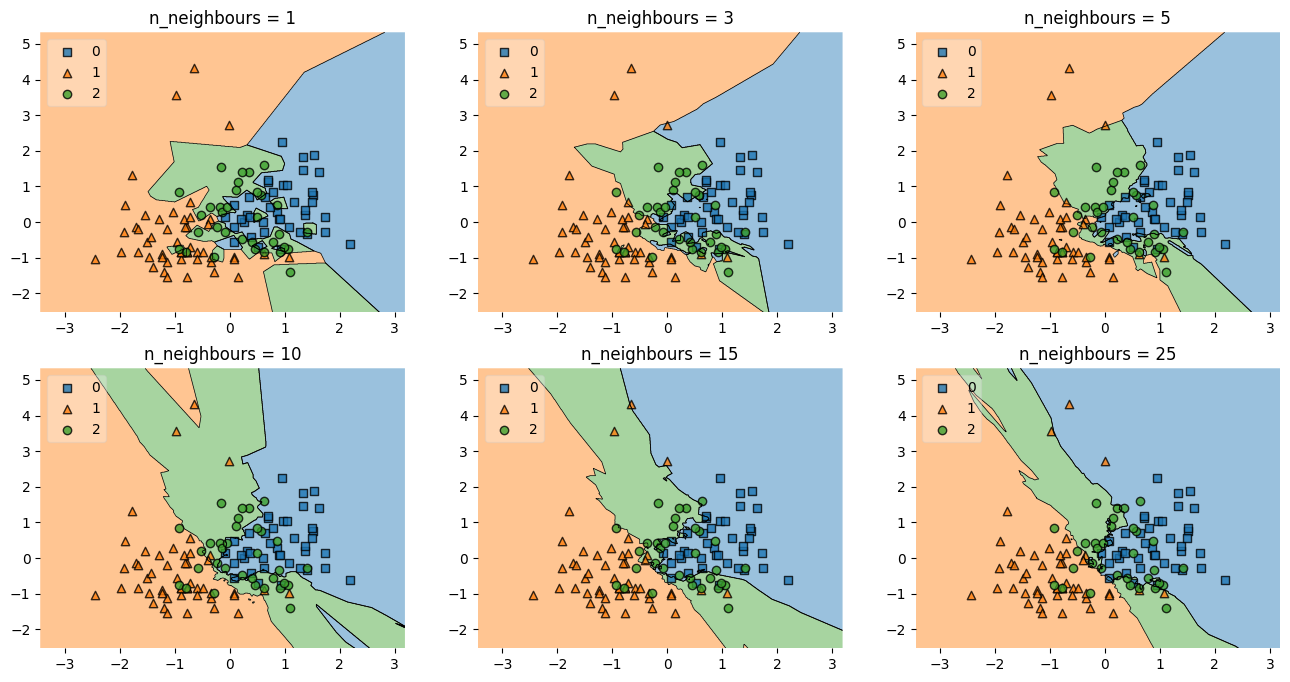

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

# Задаем формат отображения графиков.
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(16,8))

# Строим графики решающих поверхностей по обученным классификаторам.
for clf, n, grd in zip(my_clfs,
                         n_neighbors,
                         itertools.product([0, 1, 2], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_norm[['alcohol', 'magnesium']].values, y=y_train, clf=clf, legend=2)
    plt.title(f'n_neighbours = {n}')

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

**Основываясь на результатах задач 1.3 и 1.5, можно сделать вывод, что оптимальное число соседей для обучения классификатора - 5, так как для 5 соседей мы имеем наибольшую долю верных ответов на тренировочной и тестовой выборках.**

**О переобучении модели явно говорит построенная решающая поверхность для классификатора с большим числом соседей (в нашем случае - 15 и 25), так как относительно большим скоплениям зеленых точек (представители класса 2) ошибочно присвоен 0 или 1 класс. Это связано с тем, что класс 2 просто составляет маленькую пропорцию от общего объема выборки из-за чего большое число соседей может выдавать неверное предсказание.**

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

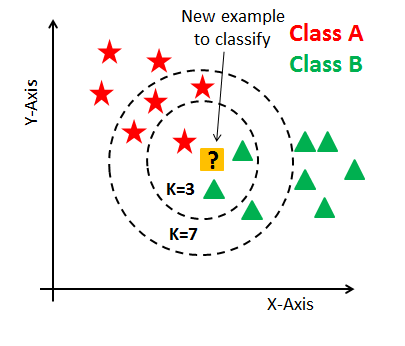

In [ ]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X = X
      self.y = y
      pass

    def predict(self, X):
      answer = np.zeros(len(X))

      for i in range(len(X)):
        distances = self.count_distance(self.X, X[i])    # Считаем расстояние до всех соседей.
        knn = np.argsort(distances)[:self.k]             # K ближайших соседей.
        y = self.y[knn]                                  # Берем классы k ближайших соседей.
        answer[i] = np.argmax(np.bincount(y))            # Выбираем самый распространенный среди соседей класс для каждого объекта выборки.
      return answer
      pass

    def count_distance(self, x, y):
      return np.sqrt(np.sum((x - y) ** 2, axis=1))  # Считаем евклидово расстояние.
      pass

In [ ]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [ ]:
data = pd.read_csv('https://github.com/hse-ds/iad-intro-ds/raw/eb2cd3de1f0d30edc2fedb958bf67397408dd324/2024/homeworks/hw04_knn_linreg/diamonds.csv?raw=true')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [ ]:
# В наборе данных отсутствуют пропущенные значения.
data.isnull().sum()

# Можно считать первый столбец индексов бессмысленным, удалим его.
data.drop (columns=data.columns[0], axis= 1, inplace=True)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [ ]:
data.drop(['cut', 'color', 'clarity', 'price'], axis=1).apply(lambda x: x.corr(data['price']))

carat    0.921591
depth   -0.010647
table    0.127134
x        0.884435
y        0.865421
z        0.861249
dtype: float64

**C целевой переменной больше всего коррелируют вес (в каратах) и длина (в мм) по x, y и z.**

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     ['cut', 'color', 'clarity']))
# Переводим категориальные признаки в числовые.
data_transformed = pd.DataFrame(transformer.fit_transform(data).toarray(), columns=transformer.get_feature_names_out())
data_transformed.index = data.index\

# Добавляем полученные столбцы в датасет.
data = pd.concat([data, data_transformed], axis=1)

# Удаляем из него категориальные признаки.
data.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)

data.head(5)

,carat,depth,table,price,x,y,z,onehotencoder__cut_Fair,onehotencoder__cut_Good,onehotencoder__cut_Ideal,...,onehotencoder__color_I,onehotencoder__color_J,onehotencoder__clarity_I1,onehotencoder__clarity_IF,onehotencoder__clarity_SI1,onehotencoder__clarity_SI2,onehotencoder__clarity_VS1,onehotencoder__clarity_VS2,onehotencoder__clarity_VVS1,onehotencoder__clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [ ]:
from sklearn.model_selection import train_test_split

# stratify применить нельзя, так как целевая переменная подразумевает регрессию, а не классификацию.
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), data['price'], test_size=0.3, random_state=7)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Масштабируем вещественные признаки.
normalizer = StandardScaler()
X_train_norm_np = normalizer.fit_transform(X_train)
X_test_norm_np = normalizer.fit_transform(X_test)

X_train_norm = pd.DataFrame(data=X_train_norm_np, columns=X_train.columns)
X_test_norm = pd.DataFrame(data=X_test_norm_np, columns=X_test.columns)

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear = LinearRegression().fit(X_train_norm, y_train)
print('Linear regression:')
print(f'MSE on train = {mean_squared_error(linear.predict(X_train_norm), y_train)}')
print(f'MSE on test = {mean_squared_error(linear.predict(X_test_norm), y_test)}')

Linear regression:
MSE on train = 1288746.8842464427
MSE on test = 1249052.0368720384


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
pd.DataFrame(data=lin_reg.coef_.T, index=X_train_norm.columns.to_list())

,0
carat,5296.388642
depth,-94.355003
table,-59.382726
x,-1087.882560
y,-6.022973
z,-20.383528
onehotencoder__cut_Fair,-129.495731
onehotencoder__cut_Good,-37.920078
onehotencoder__cut_Ideal,49.973723
onehotencoder__cut_Premium,19.521109


**Оценки коэффициентов по модулю веса (в каратах) и длины по x (в мм) на порядок превышают оценки прочих вещественных переменных.**

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10).fit(X_train_norm, y_train)
print('Lasso regression:')
pd.DataFrame(data=lasso.coef_.T, index=X_train_norm.columns.to_list())

Lasso regression:


,0
carat,4840.175983
depth,-62.091740
table,-46.135214
x,-646.245425
y,-0.000000
z,-32.211986
onehotencoder__cut_Fair,-131.644824
onehotencoder__cut_Good,-40.317512
onehotencoder__cut_Ideal,38.145547
onehotencoder__cut_Premium,0.000000


In [127]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10).fit(X_train_norm, y_train)
print('Ridge regression:')
pd.DataFrame(data=ridge.coef_.T, index=X_train_norm.columns.to_list())

Ridge regression:


,0
carat,5260.169638
depth,-91.880326
table,-59.143006
x,-1045.680078
y,-9.034507
z,-24.423939
onehotencoder__cut_Fair,-129.697101
onehotencoder__cut_Good,-38.006726
onehotencoder__cut_Ideal,49.964433
onehotencoder__cut_Premium,19.499270


**Полученные в ходе обучения Lasso и Ridge регрессий результаты говорят о том, что проблема мультиколлинеарности имела место в изначальной регрессии, однако была несущественна, так как Lasso и Ridge оценки коеффициентов оказались слегка меньше, чем полученные в ходе оценки линейной регрессии.**

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график изменения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.489e+08, tolerance: 6.028e+07
  model = cd_fast.enet_coordinate_descent(


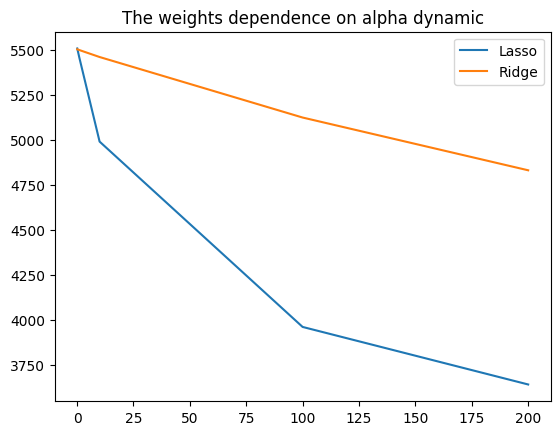

In [130]:
alpha = [0.1, 1, 10, 100, 200]
lasso_norms = []
ridge_norms = []

for i in alpha:
    lasso = Lasso(alpha=i).fit(X_train_norm, y_train)
    ridge = Ridge(alpha=i).fit(X_train_norm, y_train)
    lasso_norms.append(np.linalg.norm(lasso.coef_))
    ridge_norms.append(np.linalg.norm(ridge.coef_))

plt.plot(alpha, lasso_norms, label='Lasso')
plt.plot(alpha, ridge_norms, label='Ridge')
plt.title('The weights dependence on alpha dynamic')
plt.legend()
plt.show()

**Метод Lasso гораздо агрессивнее уменьшает веса. Lasso-регрессию удобно использовать для отбора признаков, так как сильное уменьшение весов упрощает процесс выделения отдельных признаков.**

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [133]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5, alphas=alpha).fit(X_train_norm, y_train)

print('alpha\tMSE')
for i in range(len(lasso_cv.alphas_)):
    print(f'{lasso_cv.alphas_[i]}\t{np.mean(lasso_cv.mse_path_[i])}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 885032410.1817398, tolerance: 48386684.315562025
  model = cd_fast.enet_coordinate_descent_gram(


alpha	MSE
200.0	1956168.4597250044
100.0	1540221.4476896322
10.0	1303244.5065001687
1.0	1292639.2475141273
0.1	1296444.3515431937


**Наибольшее качество (наименьшая средняя MSE) достигается при $\alpha$ = 1.**

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [134]:
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha=1).fit(X_train_norm, y_train)

print('Lasso:')
print(f'MSE on train = {mean_squared_error(lasso.predict(X_train_norm), y_train)}')
pd.DataFrame(data=lasso.coef_.T, index=X_train_norm.columns.to_list())

Lasso:
MSE on train = 1288855.811838113


,0
carat,5251.148431
depth,-91.081700
table,-58.057758
x,-1045.440403
y,-3.683766
z,-21.837426
onehotencoder__cut_Fair,-136.552315
onehotencoder__cut_Good,-49.727686
onehotencoder__cut_Ideal,28.985736
onehotencoder__cut_Premium,0.000000


**Наиболее информативные признаки: carat, x, clarity и color. Очевидно, что эти признаки будут иметь большое влияние на цену алмаза: вес напрямую коррелирует с ценой, чистота и цвет отвечают за общее качество и внешний вид камня, длина по x отвечает за размер, который как и вес напрямую коррелирует с ценой (касательно знака оценки этого признака предположу, что длина очень сильно связана с весом и поэтому, так как вес уже имеет большую положительною оценку длину пришлось делать не менеее большой, но с отрицательным знаком для достижения баланса).**

**Неинформативные признаки: depth, table, y и z. Признаки depth и table не имеют большого влияния на цену алмаза, так как его форма едва ли будет влиять на цену. Причина, по которой размеры по y и z также не оказывают сильного влияния на цену, мне неизвестна.**

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [136]:
print('Linear regression:')
print(f'MSE on test = {mean_squared_error(linear.predict(X_test_norm), y_test)}')

print('Lasso regression:')
print(f'MSE on test = {mean_squared_error(lasso.predict(X_test_norm), y_test)}')

Linear regression:
MSE on test = 1249052.0368720384
Lasso regression:
MSE on test = 1249720.165992004


**В моем случае и линейная, и Lasso регрессии показали примерно одинаковые результаты MSE (Lasso даже чуть-чуть хуже) :). Возможно мне так повезло с распределением выборок. Однако в любом случае для предсказаний стоит использовать Lasso-регрессию, так как она производит регуляризацию весов (это позволяет убрать неинформативные признаки из модели и улучшить её обобщающую способность).**